In [1]:
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
%run helpers_preproc.ipynb
%run alternate_data.ipynb

In [2]:
origDataDir = 'SHREC11/'
newDataDir = 'SHREC11_plus/'

In [3]:
#generate additional data and update label
origLabel = np.array(readLbl(600,origDataDir + 'labels.txt'),dtype = int) #first take in the original labels
newLabelFile = open(newDataDir + "labels.txt", "w")

In [4]:
for i in range(600):
    #First create the new obj file
    origN = origDataDir + 'T' + str(i) + '.obj'
    newN = newDataDir + 'T' + str(i+600) + '.obj'
    
    if not (write_new_files(origN,newN,0.008)):
        print('Data generation failed on ' , i)
        
    #Then write it into the label text file
    newLabelFile.write("T" + str(i) + ".obj" + " " + str(origLabel[i]) + "\n")
    newLabelFile.write("T" + str(i + 600) + ".obj" + " " + str(origLabel[i]) + "\n")

    
newLabelFile.close()

In [5]:
#read in the data, get normalized adjacency (NxN)
num_meshes = 1200
train_size = 900
test_size = 300
mesh_dir = 'SHREC11_plus/'
label_np = np.array(readLbl(num_meshes,mesh_dir+'labels.txt'))

In [6]:
node_sigs_list = []
normed_adjMats_list = []

for i in range(num_meshes):
    fName = 'T' + str(i) + '.obj'
    adj_noscale_read = obj_2_adj_noscale(mesh_dir + fName)
    adj_scaled_read = obj_2_adj(mesh_dir + fName)

    if (adj_scaled_read.shape[0] < 252):
        adj_noscale = np.empty([252,252])
        adj_scaled = np.empty([252,252])
    else:
        adj_noscale = adj_noscale_read
        adj_scaled = adj_scaled_read

    adj_normalized = adj_noscale / np.reshape(np.sum(adj_noscale,axis = 1),[adj_noscale.shape[0],1])

    #node level signal extraction
    node_degs = np.sum(adj_noscale,axis = 0)
    node_neigh_max = np.max(adj_scaled,axis = 0)
    node_neigh_min = np.min(adj_scaled,axis = 0)
    node_neigh_sum = np.sum(adj_scaled,axis = 0)
    node_neigh_mean = np.sum(adj_scaled,axis = 0)

    node_sig = np.stack([node_degs,node_neigh_max,node_neigh_min,node_neigh_sum,node_neigh_mean],axis = 1)
    
    node_sigs_list.append(node_sig)
    normed_adjMats_list.append(adj_normalized)

/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_3915/3132685263.py:16: RuntimeWarning: invalid value encountered in true_divide
  adj_normalized = adj_noscale / np.reshape(np.sum(adj_noscale,axis = 1),[adj_noscale.shape[0],1])


In [7]:
normed_adjMats = np.nan_to_num(np.stack(normed_adjMats_list))
node_sigs = np.nan_to_num(np.stack(node_sigs_list))

In [8]:
normed_adjMats_tr = normed_adjMats[:train_size,:,:]
node_sigs_tr = node_sigs[:train_size,:,:]
label_np_tr = label_np[:train_size]

normed_adjMats_ts = normed_adjMats[train_size:,:,:]
node_sigs_ts = node_sigs[train_size:,:,:]
label_np_ts = label_np[train_size:]

label_mat_tr = torch.tensor(np.where(igl.all_pairs_distances(label_np_tr,label_np_tr,False) > 0.5,0,1)).float()
label_mat_ts = torch.tensor(np.where(igl.all_pairs_distances(label_np_ts,label_np_ts,False) > 0.5,0,1)).float()

In [9]:
normed_adjMats_tr = torch.tensor(normed_adjMats_tr).float()
node_sigs_tr = torch.tensor(node_sigs_tr).float()
label_np_tr = torch.tensor(label_np_tr).float()

normed_adjMats_ts = torch.tensor(normed_adjMats_ts).float()
node_sigs_ts = torch.tensor(node_sigs_ts).float()
label_np_ts = torch.tensor(label_np_ts).float()

In [19]:
#label_mat_train = form_label_matrix(label_mat, train_dict)

In [20]:
#normed_adjMats_list_train, node_sigs_list_train = prep_data(train_dict)

In [21]:
#normed_adjMats_train = np.stack(normed_adjMats_list_train)
#node_sigs_train = np.stack(node_sigs_list_train)

#normed_adjMats_train = torch.tensor(normed_adjMats_train,requires_grad=False).float()
#node_sigs_train = torch.tensor(node_sigs_train,requires_grad=False).float()

#normed_adjMats_train = torch.nan_to_num(normed_adjMats_train,0,0,0)
#node_sigs_train = torch.nan_to_num(node_sigs_train,0,0,0)

In [11]:
node_sigs_tr.shape

torch.Size([900, 252, 5])

In [12]:
%run NNs.ipynb
g = GCN(5,[10,10,10,10])
n = MLP(252*10,[5,5,5,5])
output1 = g.forward(normed_adjMats_tr,node_sigs_tr)
output2 = n.forward(output1)
print(output1.shape)
print(output2.shape)

torch.Size([900, 252, 10])
torch.Size([900, 5])


In [13]:
def useless():
    pass

def lossF(features,lbl_mat):
    disMat = torch.cdist(features,features)
    sameType = disMat * (lbl_mat-torch.diag(torch.ones(lbl_mat.shape[0])))
    diffType = disMat * (1-lbl_mat)

    diffTypeScaled = diffType * torch.exp(-diffType)
    diffTypeScaledMean = torch.sum(diffTypeScaled)/ torch.count_nonzero(diffTypeScaled)
    diffTypeMean = torch.sum(diffType)/ torch.count_nonzero(diffType)

    sameTypeMean = torch.sum(sameType) / torch.count_nonzero(sameType)
    sameTypeStd = torch.sum((sameType - sameTypeMean)**2) / torch.count_nonzero(sameType)

    toRet = sameTypeMean-diffTypeScaledMean + 0.01 * torch.sqrt(sameTypeStd)
    
    print(sameTypeMean.detach().numpy(),diffTypeMean.detach().numpy(),torch.sqrt(sameTypeStd).detach().numpy(), toRet.detach().numpy())
    return  toRet

In [ ]:
optimizer = optim.Adam(g.weights + n.weights,lr = 0.00005)
for i in range(100000):
    optimizer.zero_grad()
    output = n.forward(g.forward(normed_adjMats_tr,node_sigs_tr))
    loss = lossF(output,label_mat_tr)
    loss.backward()
    optimizer.step()

0.13244578 0.1289094 0.80870473 0.03501156
0.12632665 0.12248629 0.76613325 0.032674793
0.1246315 0.120195776 0.75770605 0.033143587
0.12616831 0.12203527 0.7532731 0.033780992
0.12196789 0.11744325 0.73414195 0.032789137
0.123580866 0.119913876 0.7306949 0.032125972
0.119397916 0.11519546 0.7012429 0.030950004
0.11478137 0.11068371 0.673514 0.029610286
0.11416747 0.11105396 0.6703519 0.029007606
0.11991106 0.11695288 0.694196 0.030386768
0.11768895 0.11429545 0.6799623 0.029872872
0.10318736 0.10012559 0.5994916 0.026291527
0.10897503 0.10732365 0.6238699 0.02572979
0.10667374 0.10337789 0.6130061 0.026842259
0.11086917 0.10833716 0.630622 0.02715158
0.10981043 0.107608154 0.62428087 0.026759993
0.09697635 0.09505538 0.5520644 0.022716926
0.109211095 0.10691893 0.61706334 0.026669014
0.10477258 0.10295968 0.5917655 0.024930777
0.1123085 0.11010149 0.63094693 0.027380396
0.10834305 0.108046055 0.6082759 0.024484403
0.10403663 0.10226148 0.58521914 0.025237797
0.10117138 0.10031754 0.56

0.018086731 0.020192442 0.103508584 0.00012487441
0.012819033 0.015352763 0.07382575 -0.0011003326
0.009597721 0.012538422 0.05762964 -0.0017363909
0.0134766195 0.015595819 0.07788931 -0.0005720853
0.017054928 0.01899057 0.09750987 6.948243e-05
0.017834738 0.020465152 0.101093 -0.00056401093
0.018475922 0.020981815 0.10576708 -0.00015465228
0.019225238 0.021627119 0.110271186 0.000109624
0.01895698 0.021274725 0.10820612 3.0035502e-05
0.019608494 0.021668542 0.110978894 0.00023361365
0.017441638 0.020068364 0.09953615 -0.0005318846
0.01562993 0.017936282 0.08964864 -0.0004628534
0.012742361 0.015293834 0.07300085 -0.0011650048
0.010445035 0.013105566 0.06069124 -0.0015164434
0.010111386 0.013170291 0.059975777 -0.0018285699
0.011662777 0.014139696 0.06652333 -0.0012980246
0.014695393 0.01704816 0.08414486 -0.000697087
0.013543399 0.01617058 0.07813039 -0.0010533774
0.0130218165 0.01552781 0.07305867 -0.0012808875
0.012954544 0.015728222 0.07229895 -0.0015913732
0.013225851 0.01580073 0

0.014058146 0.019184342 0.07995477 -0.0035017256
0.0138550885 0.019051533 0.077609695 -0.0037602282
0.015065314 0.020203967 0.08540467 -0.0034246577
0.01544927 0.020559572 0.08739912 -0.0033483747
0.014870489 0.020095875 0.083639264 -0.003612215
0.014360796 0.019759571 0.082041144 -0.0036757784
0.014213764 0.019219365 0.08069697 -0.0034085717
0.01480978 0.020145291 0.08478705 -0.0035265218
0.014775389 0.020273045 0.08354699 -0.0038148612
0.015251321 0.020615563 0.08619678 -0.0036383849
0.014894698 0.02039539 0.08367087 -0.0038820049
0.015574897 0.020778075 0.088519014 -0.0033686126
0.014840413 0.020175902 0.08393144 -0.0036493847
0.014479157 0.019770283 0.082645714 -0.0035534785
0.014948909 0.020265037 0.08619376 -0.0034025782
0.0147877075 0.020247862 0.0843059 -0.0036900959
0.01512866 0.0204835 0.08629937 -0.00353008
0.014526908 0.019971108 0.08179931 -0.0038458644
0.01478043 0.020441338 0.08423404 -0.0038786829
0.014986128 0.020744903 0.08599098 -0.0038729748
0.015318827 0.020550938 

In [ ]:
output = n.forward(g.forward(normed_adjMats_tr,node_sigs_tr))
output.shape

In [ ]:
disMat = torch.cdist(output,output).flatten()
mask_same = torch.tensor(label_mat_tr - torch.diag(torch.ones(train_size)),dtype=bool).flatten()
mask_diff = torch.tensor(1 - label_mat_tr,dtype=bool).flatten()
sameComp = disMat[mask_same].detach().numpy()
diffComp = disMat[mask_diff].detach().numpy()
weightsSame = np.ones_like(sameComp) / len(sameComp)
weightsDiff = np.ones_like(diffComp) / len(diffComp)

In [ ]:
print(np.mean(diffComp),np.mean(sameComp))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(sameComp,bins=np.arange(0,np.max(sameComp),0.01),weights=weightsSame,log = False)
ax1.set_title('Same Comp')
ax2.hist(diffComp,bins=np.arange(0,np.max(diffComp),0.01),weights=weightsDiff,log = False)
ax2.set_title('Diff Comp')

In [ ]:
output = n.forward(g.forward(normed_adjMats_ts,node_sigs_ts))
output.shape

In [250]:
disMat = torch.cdist(output,output).flatten()
mask_same = torch.tensor(label_mat_ts - torch.diag(torch.ones(test_size)),dtype=bool).flatten()
mask_diff = torch.tensor(1 - label_mat_ts,dtype=bool).flatten()
sameComp = disMat[mask_same].detach().numpy()
diffComp = disMat[mask_diff].detach().numpy()
weightsSame = np.ones_like(sameComp) / len(sameComp)
weightsDiff = np.ones_like(diffComp) / len(diffComp)

/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_16850/3817663312.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_same = torch.tensor(label_mat_ts - torch.diag(torch.ones(150)),dtype=bool).flatten()
/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_16850/3817663312.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_diff = torch.tensor(1 - label_mat_ts,dtype=bool).flatten()


0.43882027 0.22498678


Text(0.5, 1.0, 'Diff Comp')

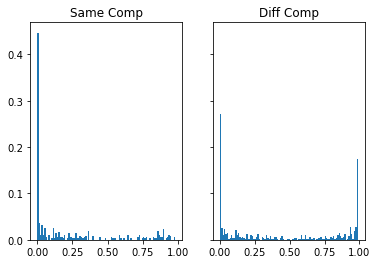

In [251]:
print(np.mean(diffComp),np.mean(sameComp))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(sameComp,bins=np.arange(0,np.max(sameComp),0.01),weights=weightsSame,log = False)
ax1.set_title('Same Comp')
ax2.hist(diffComp,bins=np.arange(0,np.max(diffComp),0.01),weights=weightsDiff,log = False)
ax2.set_title('Diff Comp')

In [230]:
#from matplotlib.pyplot import figure
#figure(figsize=(10, 8), dpi=80)


In [167]:
BigDiffIndices = np.where(disMat.detach().numpy().flatten() > 0.1)[0].tolist()

In [149]:
len(BigDiffIndices)

18906

In [150]:
vizMat = np.zeros([30,30])
vizMat

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0

In [152]:
for index in BigDiffIndices:
    row, col = divmod(index,150)
    cat1, cat2 = int(label_np[row]),int(label_np[col])
    #print(cat1,cat2, (cat1 == cat2))
    vizMat[cat1,cat2] += 1
    vizMat[cat2,cat1] += 1


In [153]:
vizMat = vizMat / np.max(vizMat)
vizMat

array([[0.2       , 0.22758621, 0.17586207, 0.62758621, 0.15172414,
        0.2137931 , 0.34137931, 0.37931034, 0.27586207, 0.22068966,
        0.15862069, 0.24482759, 0.36206897, 0.25517241, 0.32413793,
        0.43793103, 0.46206897, 0.1862069 , 0.25862069, 0.30344828,
        0.38275862, 0.47931034, 0.13448276, 0.49310345, 0.44482759,
        0.43103448, 0.31724138, 0.10344828, 0.1862069 , 0.21724138],
       [0.22758621, 0.1862069 , 0.13793103, 0.57931034, 0.12758621,
        0.19655172, 0.30344828, 0.29655172, 0.22068966, 0.16551724,
        0.14827586, 0.21034483, 0.29310345, 0.20689655, 0.24482759,
        0.35172414, 0.34137931, 0.15862069, 0.19655172, 0.25517241,
        0.29310345, 0.37586207, 0.10689655, 0.36896552, 0.36896552,
        0.35517241, 0.25172414, 0.0862069 , 0.18275862, 0.23103448],
       [0.17586207, 0.13793103, 0.04137931, 0.46551724, 0.05517241,
        0.10689655, 0.2       , 0.18965517, 0.11034483, 0.07586207,
        0.06206897, 0.12413793, 0.19655172, 0.

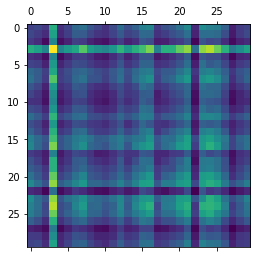

In [154]:
plt.matshow(vizMat)